In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



# Prep Master Data Frame

In [102]:
#create master player data

e_fg_df = pd.read_csv("e_fg.txt", sep=",")
e_fg_df = e_fg_df[['Player', 'eFG%▼']]
e_fg_df.columns = ['Player', 'eFG%']
names = list(e_fg_df['Player'])
names = [item.partition("\\")[0] for item in names]
e_fg_df['Player'] = names

#link names with ID
text = open("Hackathon_player_names_matched_team.txt")
line = text.readline()
line = text.readline()
IDtoName = {} # ID as keys
NametoID = {} # name as keys

while line != "" :
    data = line.split()
    name = data[4] + " " + data[5]
    name = name.replace("\"","")
    ID = (float(data[3]))
    if ID not in IDtoName:
        IDtoName[ID] = name
    if name not in NametoID:
        NametoID[name] = ID
    line = text.readline()
    
#print(NametoID["LeBron James"])
#print(IDtoName[2544])

shot_df_name = pd.read_csv("Hackathon_sv_shot_summary_2015-16.txt", sep=" ")
#have 165 occurences of null for closet defender id
shot_df_name = shot_df_name.replace({'(null)': -1})
#shot_df = shot_df.drop(shot_df.index[222316])
shot_df_name = shot_df_name[shot_df_name['SEASON'] != "GAME_ID"]
shot_df_name = shot_df_name[['PERSON_ID', 'SV_PLAYER_ID']]
#convert columns to numbers
shot_df_name[['PERSON_ID', 'SV_PLAYER_ID']] = shot_df_name[['PERSON_ID', 'SV_PLAYER_ID']].apply(pd.to_numeric).drop_duplicates()
names_df = pd.DataFrame(list(NametoID.items()), columns = ['NAME', 'PERSON_ID'])
names_df = pd.merge(names_df, shot_df_name,  how='left', left_on='PERSON_ID', right_on = 'PERSON_ID')
names_df = names_df.dropna()




/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3,5,6,8,9,11,12,13,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [142]:
#eFG%
e_fg_df_all = names_df.merge(e_fg_df, how = "left", left_on = 'NAME', right_on = 'Player')
e_fg_df_all = e_fg_df_all[['NAME', 'eFG%', 'SV_PLAYER_ID']]

#0.502 is average shooting percentage. Might want to drop because we have the best shooters
e_fg_df_all.fillna(value = 0.502, inplace = True)

#Blocks
blocks_df = pd.read_csv("blocks.txt", sep=",")
blocks_df = blocks_df[['Player', 'BLK▼']]
blocks_df.columns = ['Player', 'BLK']
names = list(blocks_df['Player'])
names = [item.partition("\\")[0] for item in names]
blocks_df['Player'] = names
master_df = e_fg_df_all.merge(blocks_df, how = "left", left_on = 'NAME', right_on = 'Player')
master_df.fillna(value = 0, inplace = True)
master_df = master_df[['NAME', 'eFG%', 'BLK', 'SV_PLAYER_ID']]

#Advanced Stats
adv_df = pd.read_csv("advanced_stats.txt", sep=",")
adv_df = adv_df[[
 'Player','PER','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']]
names = list(adv_df['Player'])
names = [item.partition("\\")[0] for item in names]
adv_df['Player'] = names
master_df = master_df.merge(adv_df, how = "left", left_on = 'NAME', right_on = 'Player')

master_df = master_df.drop(columns = 'Player')
master_df = master_df.drop_duplicates(subset='NAME', keep="first")
master_df = master_df.drop_duplicates(subset='SV_PLAYER_ID', keep="first")


#some missing data for advanced stats. Rounded it to the average of the row
master_df.fillna(round(master_df.mean(), 3), inplace=True)

rpm_df = pd.read_csv("rpm.csv", sep=",")

rpm_df = rpm_df[['NAME', 'ORPM', 'DRPM', 'RPM']]
names = list(rpm_df['NAME'])
names = [item.partition(",")[0] for item in names]
rpm_df['NAME'] = names

master_df = master_df.merge(rpm_df, how = "left", left_on = 'NAME', right_on = 'NAME')
master_df = master_df.fillna(value = 0)



In [143]:
master_df

,NAME,eFG%,BLK,SV_PLAYER_ID,PER,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,ORPM,DRPM,RPM
0,Josh Smith,0.502,0.0,3834.0,10.600,-1.200,1.200,0.000,0.000,-3.600,1.600,-2.000,0.00,-3.14,1.05,-2.09
1,Marvin Williams,0.554,1.0,3928.0,16.800,4.700,3.200,7.800,0.161,1.700,1.000,2.700,2.70,2.08,0.59,2.67
2,Jason Terry,0.502,0.1,3333.0,10.200,1.100,0.400,1.500,0.057,-0.200,-2.600,-2.800,-0.30,-0.33,-2.81,-3.14
3,Kent Bazemore,0.517,0.5,5102.0,13.400,0.300,3.800,4.100,0.094,-1.300,1.600,0.300,1.20,-1.49,0.15,-1.34
4,Joe Johnson,0.509,0.0,3520.0,12.000,1.900,0.800,2.700,0.048,0.300,-1.600,-1.300,0.40,0.80,-0.24,0.56
5,Tim Hardaway,0.502,0.0,5194.0,11.700,0.900,1.000,1.900,0.105,-0.900,-1.200,-2.100,0.00,0.00,0.00,0.00
6,Thabo Sefolosha,0.502,0.5,4141.0,12.400,1.300,3.200,4.500,0.122,-1.700,2.800,1.100,1.40,-1.97,1.62,-0.35
7,Al Horford,0.547,1.5,4245.0,19.400,4.900,4.500,9.400,0.172,1.500,2.600,4.100,4.10,0.89,2.08,2.97
8,Lamar Patterson,0.502,0.0,5359.0,5.100,-0.300,0.500,0.200,0.025,-4.600,-0.300,-4.900,-0.30,-1.76,-0.53,-2.29
9,Boris Diaw,0.502,0.3,3724.0,14.000,1.600,2.200,3.800,0.132,-0.100,1.400,1.200,1.10,-0.57,0.64,0.07


# Prep Shot DataFrame

In [105]:
#prep shot dataframe
shot_df = pd.read_csv("Hackathon_sv_shot_summary_2015-16.txt", sep=" ")

#have 165 occurences of null for closet defender id
shot_df = shot_df.replace({'(null)': -1})

#shot_df = shot_df.drop(shot_df.index[222316])
shot_df = shot_df[shot_df['SEASON'] != "GAME_ID"]

#convert columns to numbers
shot_df[["SEASON", "GAME_ID", "SV_GAME_ID", "TEAM_ID", "SV_TEAM_ID", "PERSON_ID", "SV_PLAYER_ID", "PERIOD", "GAME_CLOCK", "WALL_CLOCK", "DRIBBLES", "SHOT_DIST", "TOUCH_TIME", "CLOSE_DEF_PERSON_ID", "CLOSE_DEF_SV_PLAYER_ID", "CLOSE_DEF_DIST", "PT_VALUE", "PTS"]] = shot_df[["SEASON", "GAME_ID", "SV_GAME_ID", "TEAM_ID", "SV_TEAM_ID", "PERSON_ID", "SV_PLAYER_ID", "PERIOD", "GAME_CLOCK", "WALL_CLOCK", "DRIBBLES", "SHOT_DIST", "TOUCH_TIME", "CLOSE_DEF_PERSON_ID", "CLOSE_DEF_SV_PLAYER_ID", "CLOSE_DEF_DIST", "PT_VALUE", "PTS"]].apply(pd.to_numeric)

#convert missed/made to 0/1
shot_df['SHOT_RESULT'] = shot_df['SHOT_RESULT'].replace({'missed': 0})
shot_df['SHOT_RESULT'] = shot_df['SHOT_RESULT'].replace({'made': 1})

#classify shot distances
shot_df.loc[shot_df['PT_VALUE'] == 3, 'SHOT_TYPE'] = "Three Pointer"
shot_df.loc[(shot_df['SHOT_DIST'] >= 15) & (shot_df['PT_VALUE'] == 2), 'SHOT_TYPE'] = "Long Two-Pointer"
shot_df.loc[(shot_df['SHOT_DIST'] >= 5) & (shot_df['SHOT_DIST'] < 15), 'SHOT_TYPE'] = "Midrange"
shot_df.loc[shot_df['SHOT_DIST']< 5, 'SHOT_TYPE'] = "Layup"


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3,5,6,8,9,11,12,13,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [106]:
#keep only select shot data
shot_df = shot_df[['SHOT_RESULT', "SHOT_DIST", "DRIBBLES", "CLOSE_DEF_DIST", "TOUCH_TIME", "SV_PLAYER_ID", "CLOSE_DEF_SV_PLAYER_ID"]]



In [137]:
shot_df

,SHOT_RESULT,SHOT_DIST,DRIBBLES,CLOSE_DEF_DIST,TOUCH_TIME,SV_PLAYER_ID,CLOSE_DEF_SV_PLAYER_ID
1,0,40.10,3,0.68,1.87,3741,5359
2,0,2.43,16,2.90,16.96,5187,4895
3,1,21.09,0,4.03,0.84,5359,4895
4,1,4.60,13,0.97,9.88,5187,4895
5,0,22.59,3,4.52,5.42,4895,4245
6,1,5.22,1,1.88,2.45,5187,5150
7,0,22.64,0,5.77,0.80,4175,4895
8,0,9.66,1,3.12,1.80,4175,5468
9,0,3.77,10,2.74,9.38,5187,4895
10,0,24.60,0,5.38,0.76,4895,4141


In [118]:
def modify_player_stats(shot_df_in, master_df_in, off_stat, def_stat):
    output_df = shot_df_in.copy()
    col_names = list(output_df)
    output_df = output_df.merge(master_df_in, how = 'left', on = 'SV_PLAYER_ID')
    col_names.append(off_stat)
    output_df = output_df[col_names]
    
    output_df = output_df.merge(master_df_in.drop(columns = [off_stat]), how = 'left', left_on = 'CLOSE_DEF_SV_PLAYER_ID', right_on = 'SV_PLAYER_ID')
    output_df = output_df.rename(index=str, columns={"SV_PLAYER_ID_x": "SV_PLAYER_ID"})
    output_df = output_df.drop(columns = 'SV_PLAYER_ID_y')
    col_names.append(def_stat)
    col_names.remove('SV_PLAYER_ID')
    col_names.remove('CLOSE_DEF_SV_PLAYER_ID')
    return output_df[col_names]


    

In [10]:
#use this to modify shooter and defender data
basic_df = modify_player_stats(shot_df, master_df, 'eFG%', 'BLK')

In [11]:
basic_df = basic_df.dropna()

In [21]:
#base split using eFG and blocks

no_name_shot_df = basic_df.drop(columns = ['SV_PLAYER_ID', 'CLOSE_DEF_SV_PLAYER_ID'])
X = no_name_shot_df.drop(columns = ['SHOT_RESULT'])
Y = no_name_shot_df['SHOT_RESULT']

X_train_basic, X_test_basic, Y_train_basic, Y_test_basic = train_test_split(no_name_shot_df.drop(columns = ['SHOT_RESULT']), 
                                                    no_name_shot_df['SHOT_RESULT'], test_size=0.3, 
                                                    random_state=101)


# Logistic Regression

In [13]:
logmodel = LogisticRegression()
logmodel.fit(X_train_basic,Y_train_basic)
predictions = logmodel.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.23418654182192408

In [14]:
print(logmodel.coef_)

[[-0.06232577  0.04035023  0.09693277 -0.08071813  2.51424647 -0.13649773]]


In [15]:
coeff_df = pd.DataFrame(logmodel.coef_[0],no_name_shot_df.drop('SHOT_RESULT',axis=1).columns,columns=['Coefficient'])
coeff_df.sort_values(by=['Coefficient'])



,Coefficient
BLK,-0.136498
TOUCH_TIME,-0.080718
SHOT_DIST,-0.062326
DRIBBLES,0.040350
CLOSE_DEF_DIST,0.096933
eFG%,2.514246


In [26]:
logreg = LogisticRegression()

clf = LogisticRegressionCV(cv=5, random_state=101,
                          multi_class='multinomial', scoring = 'brier_score_loss').fit(X_train_basic, Y_train_basic)


In [29]:
predictions = clf.predict_proba(X_test_basic)
clf.score(X_test_basic,Y_test_basic)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1926: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


-0.23418763337534576

# Linear Regression

In [76]:
lm = LinearRegression()
lm.fit(X_train_basic,Y_train_basic)

print(lm.intercept_)


0.3000726771710131


In [110]:
print(lm.coef_)


[-0.014498    0.00941312  0.02132147 -0.01888836  0.60996841 -0.03184456]


In [106]:
coeff_df = pd.DataFrame(lm.coef_,no_name_shot_df.drop('SHOT_RESULT',axis=1).columns,columns=['Coefficient'])
coeff_df.sort_values(by=['Coefficient'])


,Coefficient
BLK,-0.031845
TOUCH_TIME,-0.018888
SHOT_DIST,-0.014498
DRIBBLES,0.009413
CLOSE_DEF_DIST,0.021321
eFG%,0.609968


In [80]:
print('R^2:', r2_score(Y_test_basic, predictions))

R^2: 0.054349776815785344


# Decision Tree

In [113]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_basic,Y_train_basic)

predictions = dtree.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.37946943483275664

Depth Tuning

In [120]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train_basic, Y_train_basic)
    predictions = dt.predict_proba(X_test_basic)

    predictions = predictions[:, 1]
    brier_loss = brier_score_loss(Y_test_basic, predictions)
    test_results.append(brier_loss)

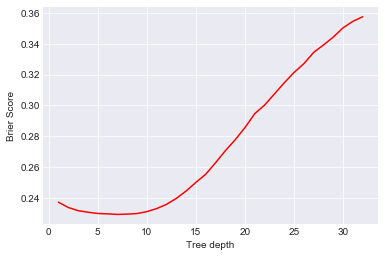

In [123]:
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('Brier Score')
plt.xlabel('Tree depth')
plt.show()

In [124]:
test_results.index(min(test_results))

6

In [125]:
min(test_results)

0.22930273662826375

In [127]:
test_results[6]

0.22930273662826375

Min_Samples_Split

In [149]:
min_samples_splits = np.linspace(0.001, 0.05, 50, endpoint=True)
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train_basic, Y_train_basic)
    predictions = dt.predict_proba(X_test_basic)

    predictions = predictions[:, 1]
    brier_loss = brier_score_loss(Y_test_basic, predictions)
    test_results.append(brier_loss)

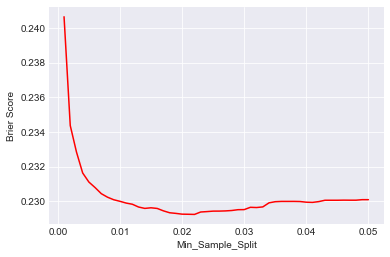

In [150]:
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.ylabel('Brier Score')
plt.xlabel('Min_Sample_Split')
plt.show()

In [151]:
print(test_results.index(min(test_results)), min(test_results))

21 0.22923668619263163


Min_samples_leaf

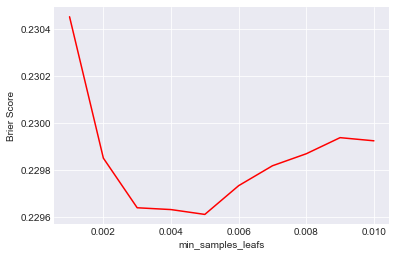

In [147]:
min_samples_leafs = np.linspace(0.001, 0.01, 10, endpoint=True)
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train_basic, Y_train_basic)
    predictions = dt.predict_proba(X_test_basic)

    predictions = predictions[:, 1]
    brier_loss = brier_score_loss(Y_test_basic, predictions)
    test_results.append(brier_loss)
    
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('Brier Score')
plt.xlabel('min_samples_leafs')
plt.show()

In [148]:
print(test_results.index(min(test_results)), min(test_results))

4 0.2296105301668084


In [152]:
dt_tuned = DecisionTreeClassifier(min_samples_leaf=0.004, min_samples_split = 0.021, max_depth = 6 )
dt_tuned.fit(X_train_basic, Y_train_basic)
predictions = dt.predict_proba(X_test_basic)

predictions = predictions[:, 1]
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss


0.2300880716380984

In [69]:
param_grid = {'max_depth': range(1, 10), 
              #'min_samples_split': np.arange(0.001, 0.05, 50),
              #'min_samples_leaf':np. arange(0.001, 0.05, 50)
              'min_samples_split': range(10, 50, 10),
              'min_samples_leaf': range(10, 50, 10)
             }

tree_grid = GridSearchCV(cv=5, estimator = DecisionTreeClassifier(), param_grid = param_grid, scoring = 'brier_score_loss')

tree_grid.fit(X_train_basic, Y_train_basic)
tree_performance = tree_grid.score(X_test_basic,Y_test_basic)



In [70]:
print(tree_grid.best_score_)

-0.22885984073956228


In [71]:
print(tree_grid.best_params_)


{'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [92]:
dt_optimized = DecisionTreeClassifier(min_samples_leaf=20, min_samples_split = 10, max_depth = 7 )
dt_optimized.fit(X_train_basic, Y_train_basic)
predictions = dt_optimized.predict_proba(X_test_basic)

predictions = predictions[:, 1]
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.22930671178441708

In [100]:
data = dict(zip(X_train_basic.columns, dt_optimized.feature_importances_))
d_tree_features = pd.DataFrame(list(data.items()), columns=['Feature', 'Importance'])

d_tree_features.sort_values(by='Importance', ascending=False)


,Feature,Importance
0,SHOT_DIST,0.614652
2,CLOSE_DEF_DIST,0.235833
3,TOUCH_TIME,0.108072
4,eFG%,0.017610
5,BLK,0.016248
1,DRIBBLES,0.007584



# Random Forest

In [153]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_basic, Y_train_basic)
predictions = rfc.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.20622126233959612

In [188]:
predictions = rfc.predict_proba(X_test_basic)

In [194]:
shot_probability = []
for i in predictions:
    shot_probability.append(round(i[1], 4))
X_test_basic['SHOT_PROB'] = shot_probability
X_test_basic

,SHOT_DIST,DRIBBLES,CLOSE_DEF_DIST,TOUCH_TIME,eFG%,BLK,SHOT_PROB
55524,4.50,11,3.81,10.21,0.459,0.6,0.73
244296,3.77,0,2.42,0.68,0.513,0.2,0.72
5819,2.55,0,2.01,0.04,0.583,0.8,0.65
153416,2.58,0,2.67,0.74,0.502,0.0,0.97
202062,16.15,5,2.40,7.02,0.471,0.2,0.37
98540,9.78,3,3.23,5.52,0.502,0.6,0.42
143997,21.19,3,3.12,4.08,0.496,0.2,0.24
232413,4.86,1,1.88,1.90,0.502,0.0,0.58
147196,4.85,2,2.65,2.68,0.494,0.2,0.57
175056,25.31,8,6.43,7.29,0.502,1.4,0.09


In [186]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_basic, Y_train_basic)
predictions = rfc.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.20706315475075326

In [155]:
rfc = RandomForestClassifier(n_estimators=200, max_features = 'sqrt')
rfc.fit(X_train_basic, Y_train_basic)
predictions = rfc.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.20627702101966444

In [156]:
rfc = RandomForestClassifier(n_estimators=200, max_features = 0.2)
rfc.fit(X_train_basic, Y_train_basic)
predictions = rfc.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.21115120606428847

In [ ]:
print(rf_grid.best_score_)

In [ ]:
print(rf_grid.best_params_)


# Boosting

In [159]:
abc = AdaBoostClassifier(n_estimators=200,
                         learning_rate=1)
abc_model = abc.fit(X_train_basic, Y_train_basic)
predictions = abc_model.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.24976136574060817

In [83]:
grad_boost = GradientBoostingClassifier()
grad_boost_model = grad_boost.fit(X_train_basic, Y_train_basic)
predictions = grad_boost_model.predict_proba(X_test_basic)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_basic, predictions)
brier_loss

0.22743442026392496

In [88]:
param_dist = {
 'n_estimators': [50, 100, 200],
 'learning_rate' : [0.01, 0.1, 0.3,1],
 }

boost_grid = GridSearchCV(cv=5, estimator = GradientBoostingClassifier(), param_grid = param_dist, scoring = 'brier_score_loss')

boost_grid.fit(X_train_basic, Y_train_basic)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='brier_score_loss', verbose=0)

In [89]:
print(boost_grid.best_score_)

-0.22651338424930192


In [90]:
print(boost_grid.best_params_)


{'learning_rate': 0.3, 'n_estimators': 200}


# Advanced Stats

RPM

In [166]:
rpm_df = modify_player_stats(shot_df, master_df, 'ORPM', 'DRPM')

In [167]:
rpm_df.head()

,SHOT_RESULT,SHOT_DIST,DRIBBLES,CLOSE_DEF_DIST,TOUCH_TIME,ORPM,DRPM
0,0,40.10,3,0.68,1.87,-1.33,-0.53
1,0,2.43,16,2.90,16.96,0.88,0.51
2,1,21.09,0,4.03,0.84,-1.76,0.51
3,1,4.60,13,0.97,9.88,0.88,0.51
4,0,22.59,3,4.52,5.42,0.85,2.08


In [168]:
rpm_df.fillna(round(rpm_df.mean(), 3), inplace=True)

In [169]:
X_test_basic.head()

,SHOT_DIST,DRIBBLES,CLOSE_DEF_DIST,TOUCH_TIME,eFG%,BLK
55524,4.50,11,3.81,10.21,0.459,0.6
244296,3.77,0,2.42,0.68,0.513,0.2
5819,2.55,0,2.01,0.04,0.583,0.8
153416,2.58,0,2.67,0.74,0.502,0.0
202062,16.15,5,2.40,7.02,0.471,0.2


In [178]:
X_train_rpm, X_test_rpm, Y_train_rpm, Y_test_rpm = train_test_split(rpm_df.drop(columns = ['SHOT_RESULT']), 
                                                    rpm_df['SHOT_RESULT'], test_size=0.3, 
                                                    random_state=101)


In [179]:
rfc_rpm = RandomForestClassifier(n_estimators=200)
rfc_rpm.fit(X_train_rpm, Y_train_rpm)
predictions = rfc_rpm.predict_proba(X_test_rpm)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_rpm, predictions)
brier_loss

0.23443292436252264

BPM

In [180]:
bpm_df = modify_player_stats(shot_df, master_df, 'OBPM', 'DBPM')
bpm_df.fillna(round(bpm_df.mean(), 3), inplace=True)
X_train_bpm, X_test_bpm, Y_train_bpm, Y_test_bpm = train_test_split(bpm_df.drop(columns = ['SHOT_RESULT']), 
                                                    bpm_df['SHOT_RESULT'], test_size=0.3, 
                                                    random_state=101)


In [181]:
rfc_bpm = RandomForestClassifier(n_estimators=200)
rfc_bpm.fit(X_train_bpm, Y_train_bpm)
predictions = rfc_bpm.predict_proba(X_test_bpm)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_bpm, predictions)
brier_loss

0.23425293610288275

Win Share

In [182]:
ws_df = modify_player_stats(shot_df, master_df, 'OWS', 'DWS')
ws_df.fillna(round(ws_df.mean(), 3), inplace=True)
X_train_ws, X_test_ws, Y_train_ws, Y_test_ws = train_test_split(ws_df.drop(columns = ['SHOT_RESULT']), 
                                                    ws_df['SHOT_RESULT'], test_size=0.3, 
                                                    random_state=101)


In [183]:
rfc_ws = RandomForestClassifier(n_estimators=200)
rfc_ws.fit(X_train_ws, Y_train_ws)
predictions = rfc_ws.predict_proba(X_test_ws)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_ws, predictions)
brier_loss

0.23552118641833905

PER

In [184]:
per_df = modify_player_stats(shot_df, master_df, 'OWS', 'DWS')
per_df.fillna(round(per_df.mean(), 3), inplace=True)
X_train_per, X_test_per, Y_train_per, Y_test_per = train_test_split(per_df.drop(columns = ['SHOT_RESULT']), 
                                                    per_df['SHOT_RESULT'], test_size=0.3, 
                                                    random_state=101)


In [185]:
rfc_per = RandomForestClassifier(n_estimators=200)
rfc_per.fit(X_train_per, Y_train_per)
predictions = rfc_per.predict_proba(X_test_per)

predictions = predictions[:, 1]
    
# for a visual skip to later in the qualitative look
brier_loss = brier_score_loss(Y_test_per, predictions)
brier_loss

0.23529483376737428